### Research Process 


#### Init Libraries

In [1]:
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import os

#### Load Dataset and split into Features and Label

In [2]:
#load data
df=pd.read_csv("breast-cancer-wisconsin-data/data.csv")
#drop irelevent columns for the classification
df = df.drop(columns=['Unnamed: 32', 'id'])
# rearange the data for X - featuers and Y leabels 
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

#### Encode Labels

In [3]:
le = LabelEncoder()
y = le.fit_transform(y)

#### The mapping of the labels

In [4]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'B': 0, 'M': 1}


#### Splitting the data into Train, Test and Valid datasets

In [5]:
#split the data
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

#### Scale the data

In [6]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X_train_val = X_train_val.values

In [7]:
X_train

array([[ 3.36206897e-01, -6.44558617e-01,  3.37819186e-01, ...,
         4.37008710e-01,  4.52719971e-01,  2.48078267e-01],
       [ 4.79064039e-01,  2.22886502e+00,  6.01104210e-01, ...,
         1.45570427e+00,  1.82256298e+00,  2.86489634e+00],
       [ 1.07142857e-01, -1.86828585e-03,  9.48930297e-02, ...,
         3.16974719e-01,  1.16830960e-02,  5.08036338e-01],
       ...,
       [-1.41625616e-01, -1.21812237e+00, -1.75983437e-01, ...,
        -1.73358827e-01, -9.63855422e-02,  7.09760075e-01],
       [ 3.26354680e-01,  8.59411490e-01,  2.75707384e-01, ...,
         3.96643297e-01, -5.31580869e-01, -5.14558584e-01],
       [-1.49014778e-01, -2.59691733e-01, -1.63216011e-01, ...,
        -4.51880178e-01, -2.23439211e-01, -4.90333100e-01]])

#### Handling the imbalance between the classes

In [8]:
#handling imbalance data 
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
#the class weight is done only on the train data to impact the learning process and to evaluete beter the model proformence
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.7878787878787878, 1: 1.368421052631579}

as predicted the minorty class 'M'=1 gets higher weight of 1.368

### Neural Networks

##### Init Libraries

In [9]:
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.regularizers import l1, l2
#from keras.layers import Dropout, Flatten, BatchNormalization
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics
from keras import callbacks
from keras import utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf

##### Function Helpers

In [10]:
def model_result(model):
    print('================================================================================')
    print(f'Evaluation Report for Model: {model.name}')

    # accuracy
    result = model.evaluate(X_test, y_test, verbose=0)        
    print(f'Loss Value: {result[0]:.3f}, Accuracy: {result[1]*100:.3f}%')

    # confusion matrix
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.round(y_prob).astype(int)    
    cm_test = confusion_matrix(y_test, y_pred)    
    #sns.heatmap(cm_test,annot=True)
    cm_disp = ConfusionMatrixDisplay(cm_test, display_labels=le.classes_)
    cm_disp.plot()
    plt.show()

    # classification report
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print(report)

    print('Model Summary:')
    print(model.summary())
    print('================================================================================')

In [11]:
def model_history(history):
    plt.figure(figsize=(15,6))

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.plot(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], 'r*', label='Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_loss'][val_loss_min_pos]:.3f})', va='bottom')
    plt.legend()

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], 'r*', label='Validation Accuracy @ Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_accuracy'][val_loss_min_pos]:.3f})', va='bottom')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.show()    

In [12]:
def proc_history(history):

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    train_acc = history.history['accuracy'][val_loss_min_pos]
    train_loss = history.history['loss'][val_loss_min_pos]

    val_acc = history.history['val_accuracy'][val_loss_min_pos]
    val_loss = history.history['val_loss'][val_loss_min_pos]

    return {'Train Accuracy': train_acc, 'Train Loss': train_loss, 'Validation Accuracy': val_acc, 'Validation Loss': val_loss}

In [40]:
def model_fit(model, optimizer=optimizers.RMSprop, learning_rate=0.001, epochNum=1000, batchSize=32, en_reduce_lr=False, en_early_stopping=True, pca=False, verbose="auto", Dataset=None):      
    
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=0)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=0)
    checkpoint_filepath = f'model_checkpoints/{model.name}_checkpoint.model.keras'
    model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0)
    
    callbacks_list = [model_checkpoint_callback]

    if en_reduce_lr:
        callbacks_list.append(reduce_lr)

    if en_early_stopping:
        callbacks_list.append(early_stopping)

    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    if Dataset is None:
        history = model.fit(X_train, y_train, batch_size=batchSize, epochs=epochNum, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=callbacks_list, verbose=verbose)
    else:
        history = model.fit(Dataset['X_train'], Dataset['y_train'], batch_size=batchSize, epochs=epochNum, validation_data=(Dataset['X_val'], Dataset['y_val']), class_weight=class_weight_dict, callbacks=callbacks_list, verbose=verbose)

    model = models.load_model(checkpoint_filepath)

    return history, model

In [45]:
def model_kfold(xtrain, ytrain, model_base, optimizer=optimizers.RMSprop,learning_rate=0.001, epochNum=1000, batchSize=32, verbose="auto"):
    model = models.clone_model(model_base)
    fold_k = StratifiedKFold(n_splits = 5).split(xtrain, ytrain)
    
    result_df = pd.DataFrame(columns=['k', 'Train Accuracy', 'Train Loss' , 'Validation Accuracy', 'Validation Loss'])
    for k , (train, valid) in enumerate(fold_k):

        scaler = RobustScaler()

        X_train = scaler.fit_transform(xtrain[train])
        X_val = scaler.transform(xtrain[valid])
        
        dataset = {'X_train': X_train, 'y_train': ytrain[train], 'X_val': X_val, 'y_val': ytrain[valid]}
        model.set_weights(model_base.get_weights())

        

        history, model = model_fit(model, optimizer=optimizer, learning_rate=learning_rate, epochNum=1000, batchSize=32, en_reduce_lr=False, en_early_stopping=True, Dataset=dataset, verbose=verbose)    
        
        train_res = model.evaluate(X_train, ytrain[train], verbose=verbose)
        val_res = model.evaluate(X_val, ytrain[valid], verbose=verbose)

        new_row = {'k': k, 'Train Accuracy': train_res[1], 'Train Loss': train_res[0], 'Validation Accuracy': val_res[1], 'Validation Loss': val_res[0]}

        result_df.loc[len(result_df)] = new_row

    return result_df

##### Build the model

In [15]:
models_list = []

### SLP

In [16]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

#### Baseline

In [17]:
CURRENT_MODEL = models.Sequential(name=f'SLP_1')

CURRENT_MODEL.add(layers.Input((30,)))
CURRENT_MODEL.add(layers.Dense(1, activation='sigmoid'))

In [18]:
model = models.clone_model(CURRENT_MODEL)
model.set_weights(CURRENT_MODEL.get_weights())

##### Baseline - Results

In [19]:
history, model = model_fit(model, epochNum=1000, batchSize=32, verbose=0)

proc_data = proc_history(history)

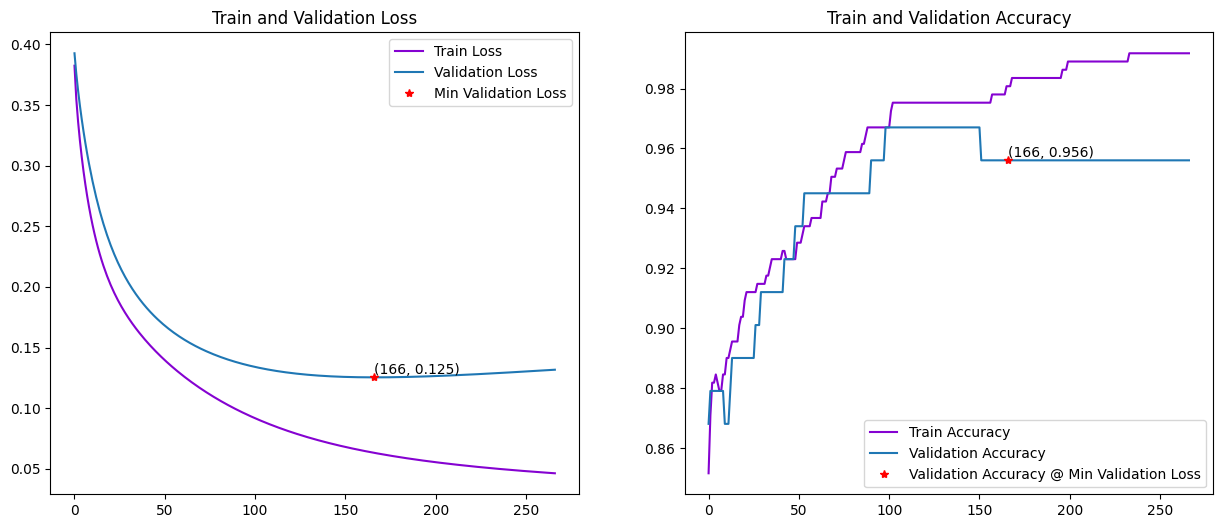

In [20]:
model_history(history)

In [21]:
model.set_weights(CURRENT_MODEL.get_weights())

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=1000, batchSize=32, verbose=0)

In [22]:
res_df

,k,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss
0,0,0.986264,0.049414,0.978022,0.072851
1,1,0.986264,0.058340,0.956044,0.115238
2,2,0.983516,0.053823,0.989011,0.020662
3,3,0.978022,0.062854,0.978022,0.098382
4,4,0.989011,0.049580,0.967033,0.105175


In [23]:
res_df['Validation Accuracy'].mean()

0.9736263751983643

#### Optimizers

------------------------------------------------------------------------------------------------------------------
Optimizer = <class 'keras.src.optimizers.adam.Adam'>


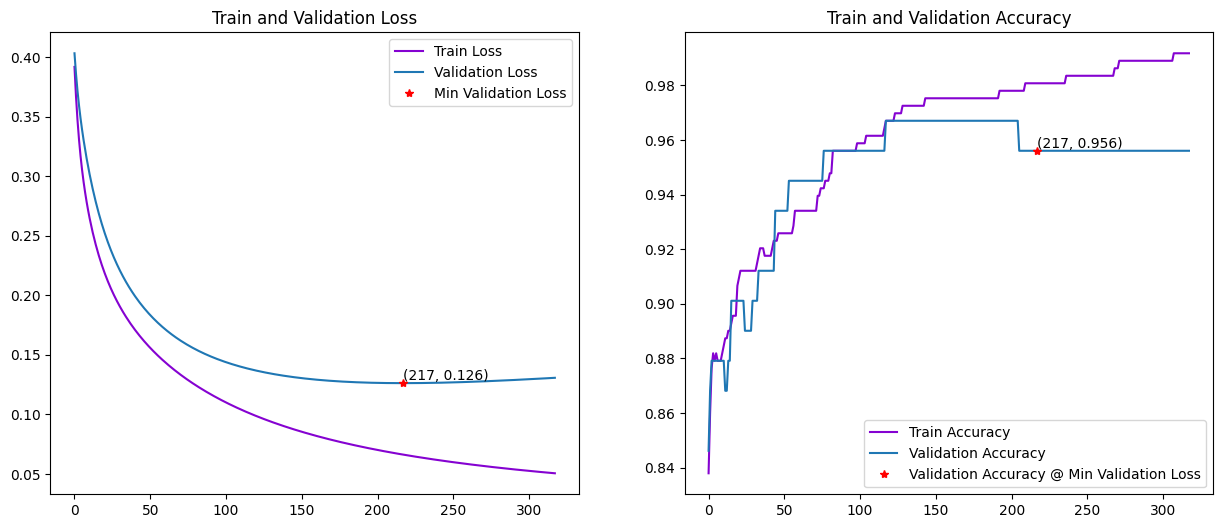

------------------------------------------------------------------------------------------------------------------
Optimizer = <class 'keras.src.optimizers.rmsprop.RMSprop'>


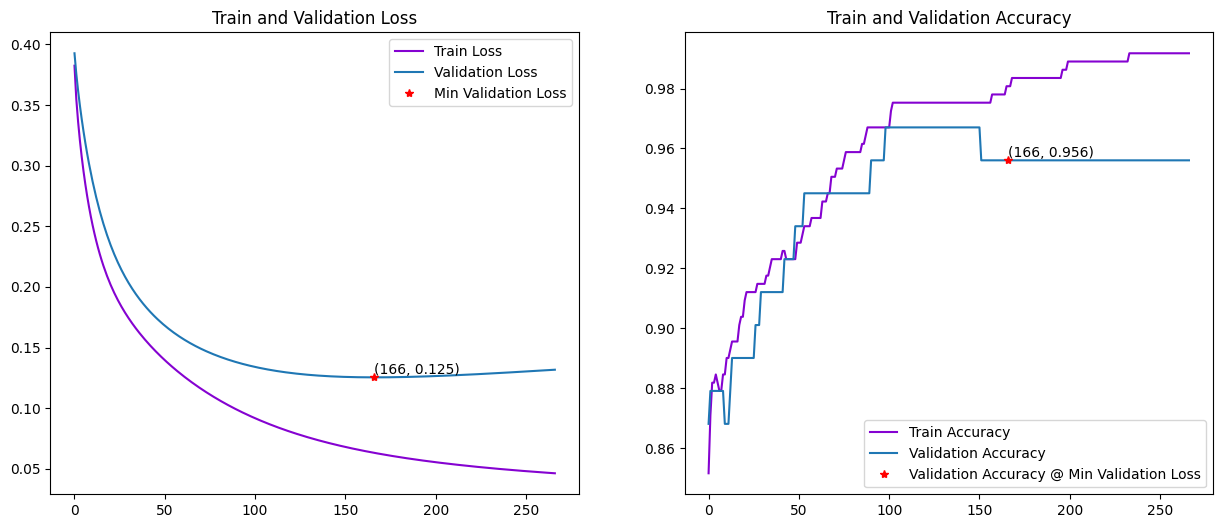

------------------------------------------------------------------------------------------------------------------
Optimizer = <class 'keras.src.optimizers.sgd.SGD'>


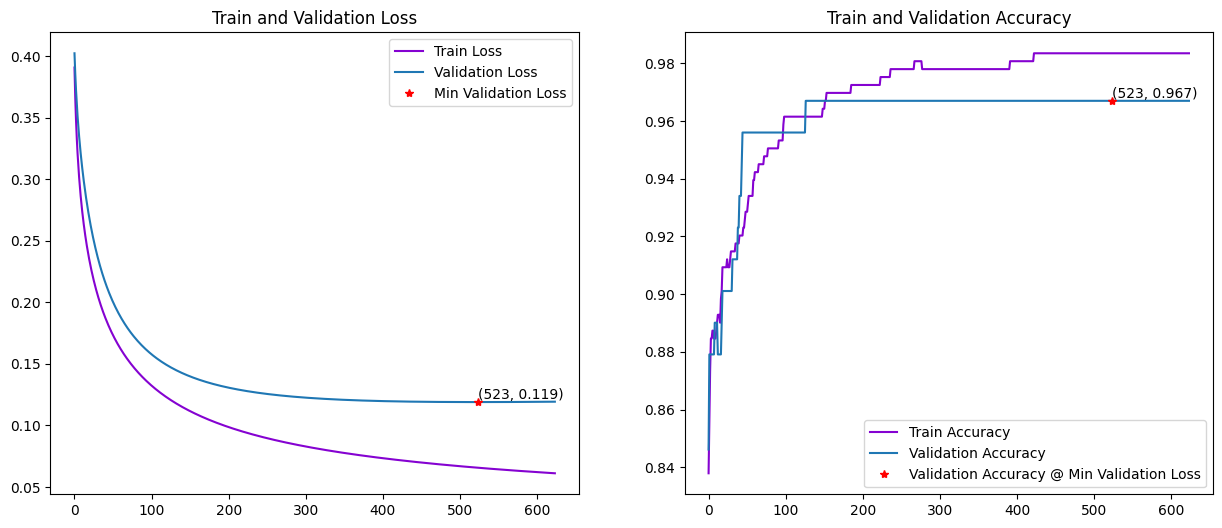

------------------------------------------------------------------------------------------------------------------
Optimizer = <class 'keras.src.optimizers.adagrad.Adagrad'>


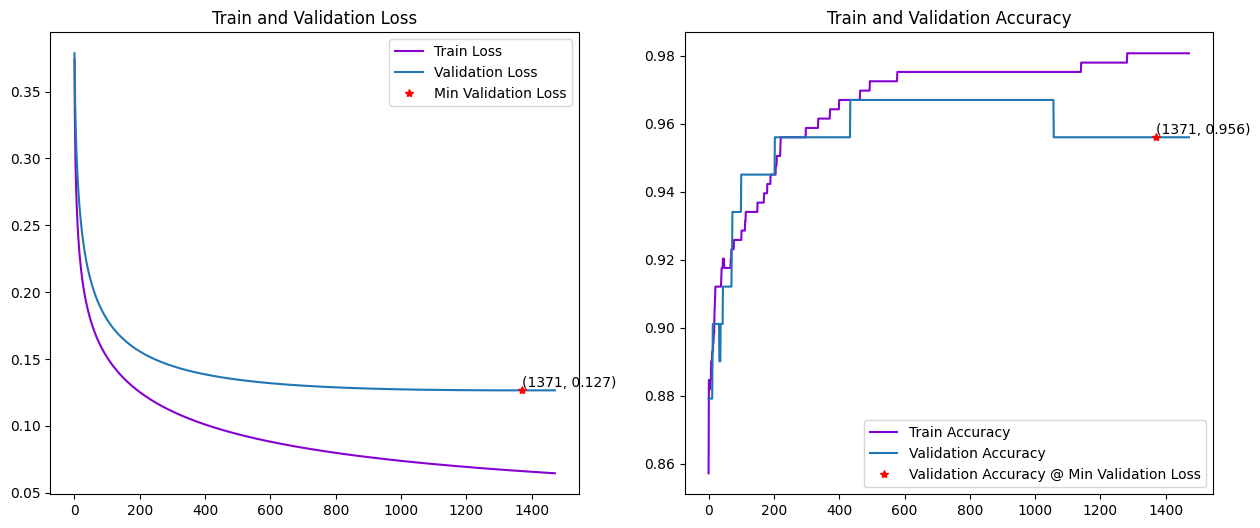

In [42]:
df_batch_size = pd.DataFrame(columns=['Optimizer', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss'])

for optimizer in [optimizers.Adam, optimizers.RMSprop, optimizers.SGD, optimizers.Adagrad]:
    print(f'------------------------------------------------------------------------------------------------------------------')
    print(f'Optimizer = {optimizer}')    
        
    model.set_weights(CURRENT_MODEL.get_weights())   

    learning_rate = 0.001
    if(optimizer == optimizers.SGD or optimizer==optimizers.Adagrad):
        learning_rate = 0.01

    history, model = model_fit(model, optimizer=optimizer, learning_rate = learning_rate, epochNum=2000, en_early_stopping=True, verbose=0)        
    proc_data = proc_history(history)
    
    new_row = {'Optimizer': optimizer, **proc_data}
    df_batch_size.loc[len(df_batch_size)] = new_row
    model_history(history)


Conclusion: We can see in the graphs that the optimizers achieve similar results, while SGD and Adagrad take a large amount of Epochs to converge.

In [61]:
model.set_weights(CURRENT_MODEL.get_weights())
ADAM_res_df = model_kfold(X_train_val, y_train_val, model, optimizer=optimizers.Adam, learning_rate=0.001, epochNum=1000, batchSize=32, verbose=0)

model.set_weights(CURRENT_MODEL.get_weights())
RMS_res_df = model_kfold(X_train_val, y_train_val, model, optimizer=optimizers.RMSprop, learning_rate=0.001, epochNum=1000, batchSize=32, verbose=0)

model.set_weights(CURRENT_MODEL.get_weights())
SGD_res_df = model_kfold(X_train_val, y_train_val, model, optimizer=optimizers.SGD, learning_rate=0.01, epochNum=1000, batchSize=32, verbose=0)

In [69]:
print(f"Validation Loss Mean: {ADAM_res_df['Validation Loss'].mean()}, Validation Loss STD: {ADAM_res_df['Validation Loss'].std()}")
ADAM_res_df

Validation Loss Mean: 0.08508216179907321, Validation Loss STD: 0.03704659783428757


,k,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss
0,0,0.980769,0.053827,0.978022,0.078401
1,1,0.986264,0.057325,0.956044,0.116546
2,2,0.983516,0.055167,0.989011,0.023635
3,3,0.978022,0.063545,0.978022,0.101506
4,4,0.983516,0.051058,0.967033,0.105323


In [70]:
print(f"Validation Loss Mean: {RMS_res_df['Validation Loss'].mean()}, Validation Loss STD: {RMS_res_df['Validation Loss'].std()}")
RMS_res_df

Validation Loss Mean: 0.08246158920228482, Validation Loss STD: 0.037931709699782476


,k,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss
0,0,0.986264,0.049414,0.978022,0.072851
1,1,0.986264,0.058340,0.956044,0.115238
2,2,0.983516,0.053823,0.989011,0.020662
3,3,0.978022,0.062854,0.978022,0.098382
4,4,0.989011,0.049580,0.967033,0.105175


In [71]:
print(f"Validation Loss Mean: {SGD_res_df['Validation Loss'].mean()}, Validation Loss STD: {SGD_res_df['Validation Loss'].std()}")
SGD_res_df

Validation Loss Mean: 0.08725217282772064, Validation Loss STD: 0.028655515721158594


,k,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss
0,0,0.975275,0.070713,0.978022,0.071256
1,1,0.986264,0.063432,0.956044,0.113698
2,2,0.978022,0.074334,0.989011,0.044762
3,3,0.978022,0.069284,0.978022,0.100967
4,4,0.980769,0.060160,0.967033,0.105578


Conclusion: We will take the best Optimizer as SGD, as it yields the lowest STD value in the Validation Loss.

In [73]:
BEST_OPTIMIZER = optimizers.SGD

#### Learning-Rate

------------------------------------------------------------------------------------------------------------------
Learning Rate = 0.1


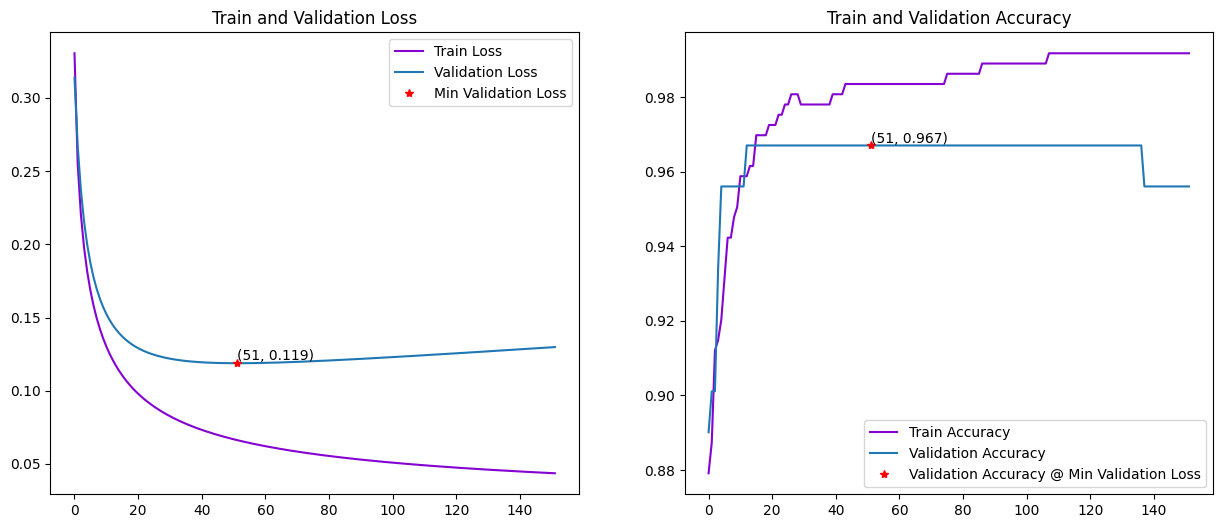

------------------------------------------------------------------------------------------------------------------
Learning Rate = 0.01


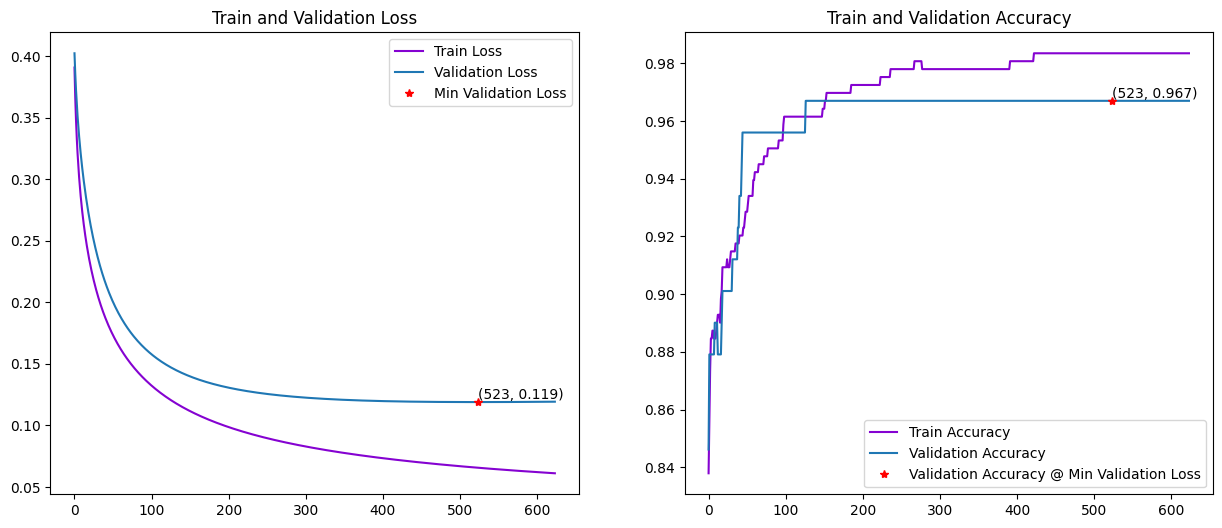

------------------------------------------------------------------------------------------------------------------
Learning Rate = 0.001


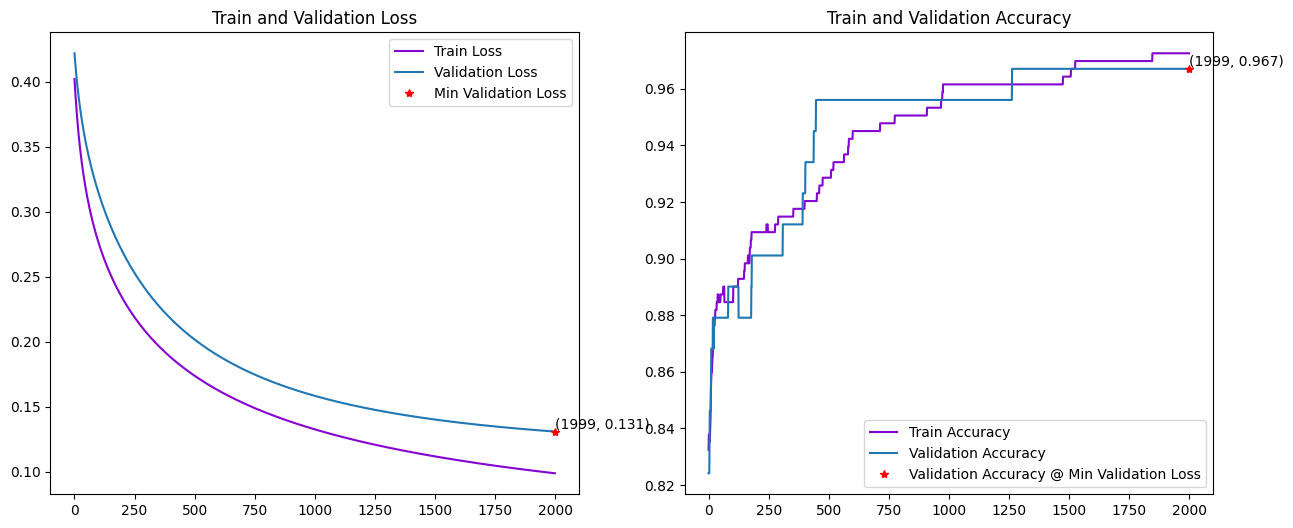

------------------------------------------------------------------------------------------------------------------
Learning Rate = 0.0001


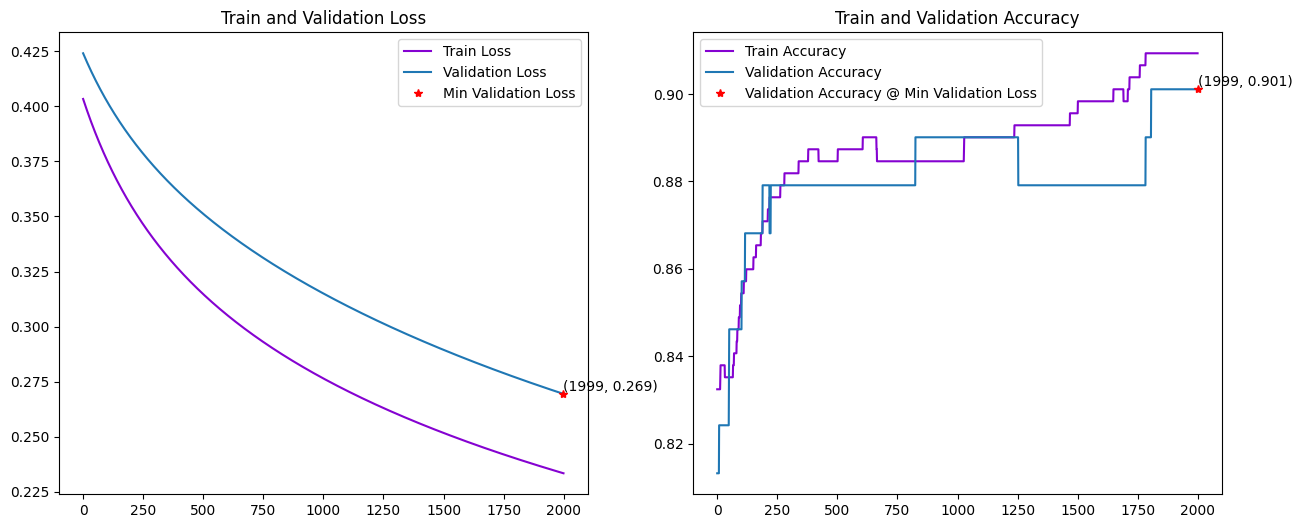

In [75]:
df_res = pd.DataFrame(columns=['Learning Rate', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss'])

for learning_rate in [0.1, 0.01, 0.001, 0.0001]:
    print(f'------------------------------------------------------------------------------------------------------------------')
    print(f'Learning Rate = {learning_rate}')    
        
    model.set_weights(CURRENT_MODEL.get_weights())   

    history, model = model_fit(model, optimizer=BEST_OPTIMIZER, learning_rate=learning_rate, epochNum=2000, en_early_stopping=True, verbose=0)
    proc_data = proc_history(history)
    
    new_row = {'Learning Rate': learning_rate, **proc_data}
    df_res.loc[len(df_res)] = new_row
    model_history(history)


Conlusion: From the graphs above, we can infer that a learning rate of 0.1 and 0.01 yields the same results, however with a learning rate of 0.1 it yields the result 10 times faster, which means the model can handle a large learning rate at the begining of the training. <br>
In the next steps, we will include a learning rate scheduler, which will decrease the learning rate once it reaches a plateau.

In [76]:
BEST_LEARNING_RATE = 0.1

#### Batch-Size

------------------------------------------------------------------------------------------------------------------
Batch Size = 1


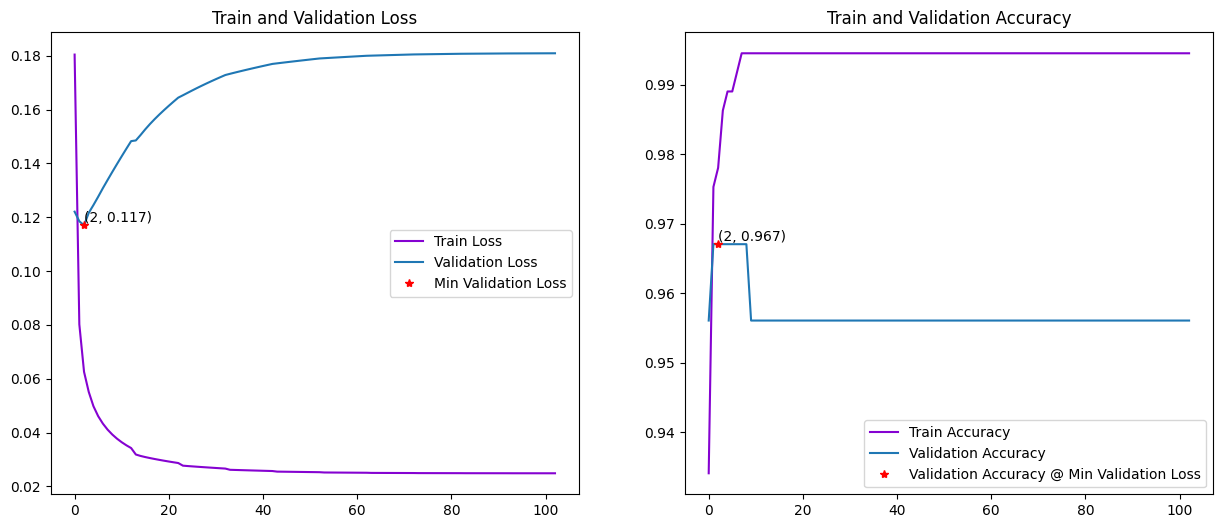

------------------------------------------------------------------------------------------------------------------
Batch Size = 2


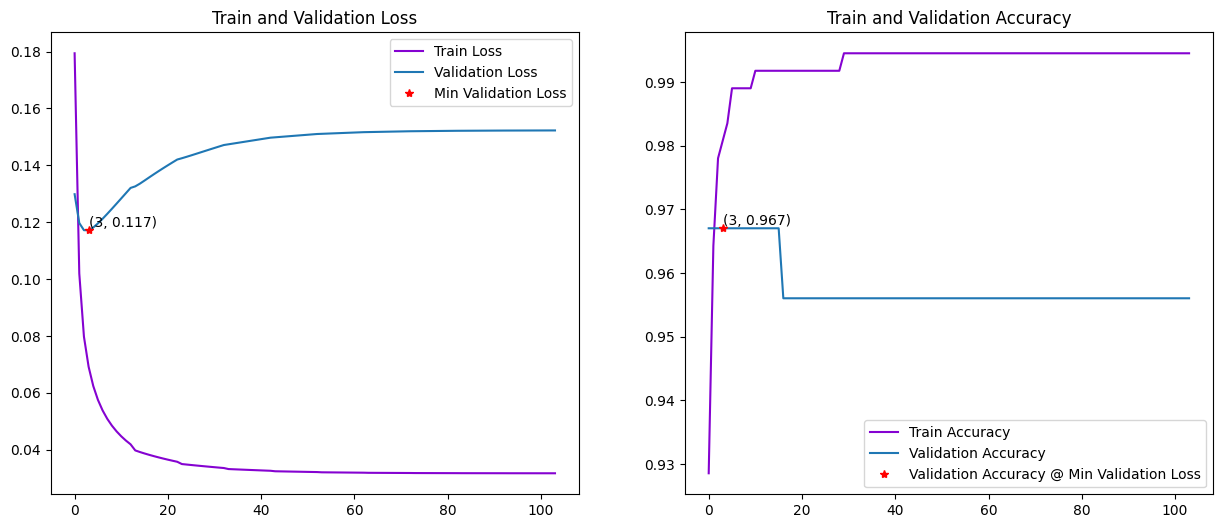

------------------------------------------------------------------------------------------------------------------
Batch Size = 4


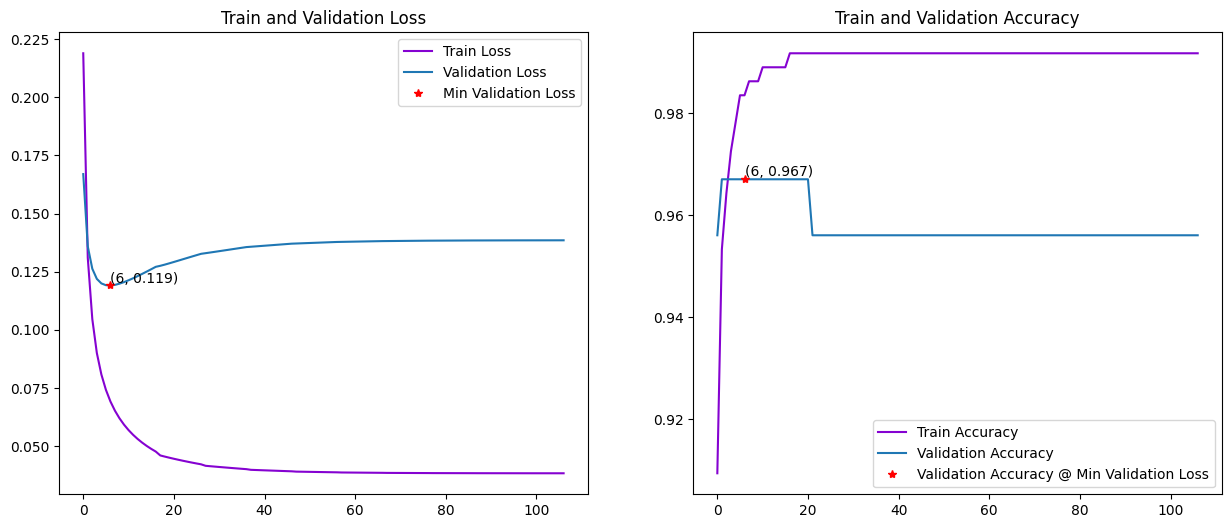

------------------------------------------------------------------------------------------------------------------
Batch Size = 8


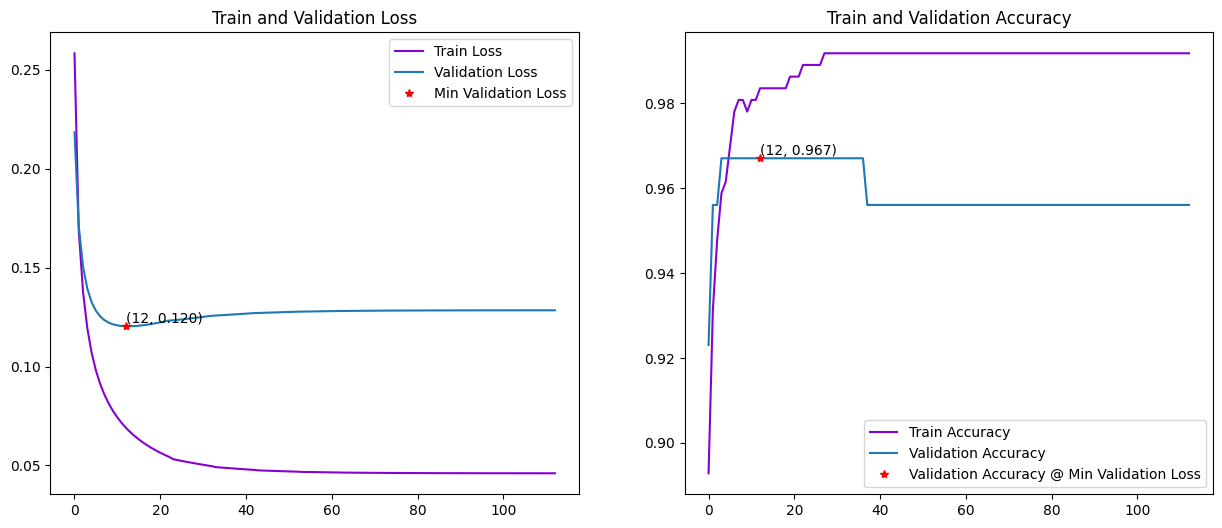

------------------------------------------------------------------------------------------------------------------
Batch Size = 16


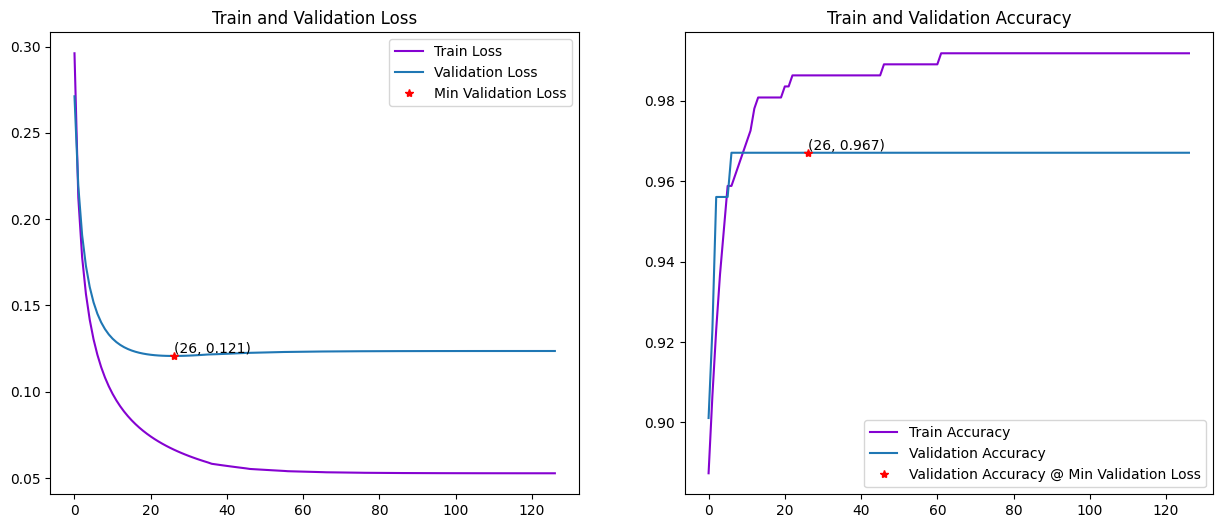

------------------------------------------------------------------------------------------------------------------
Batch Size = 32


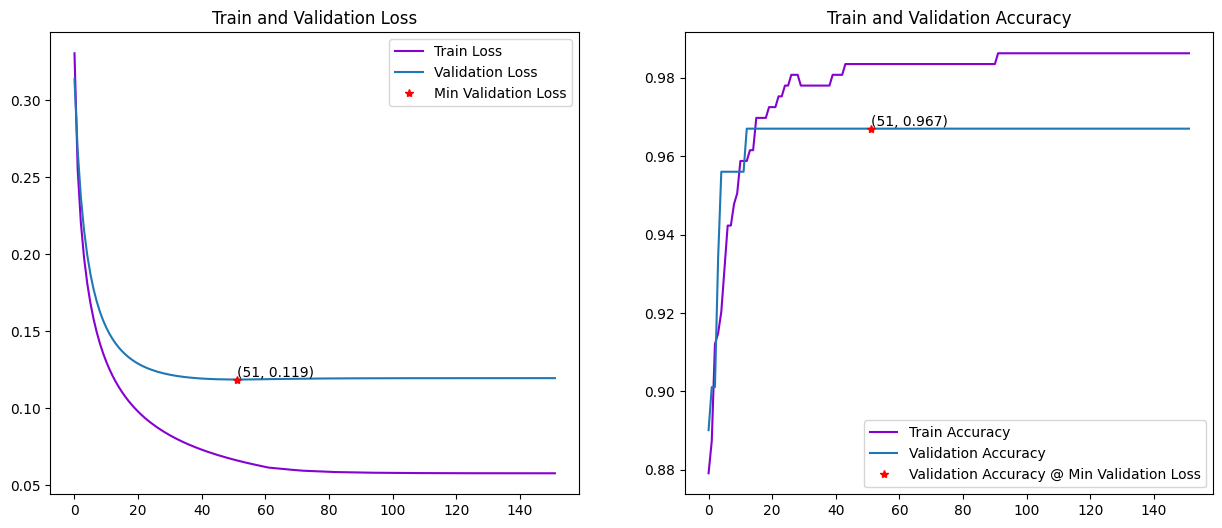

------------------------------------------------------------------------------------------------------------------
Batch Size = 64


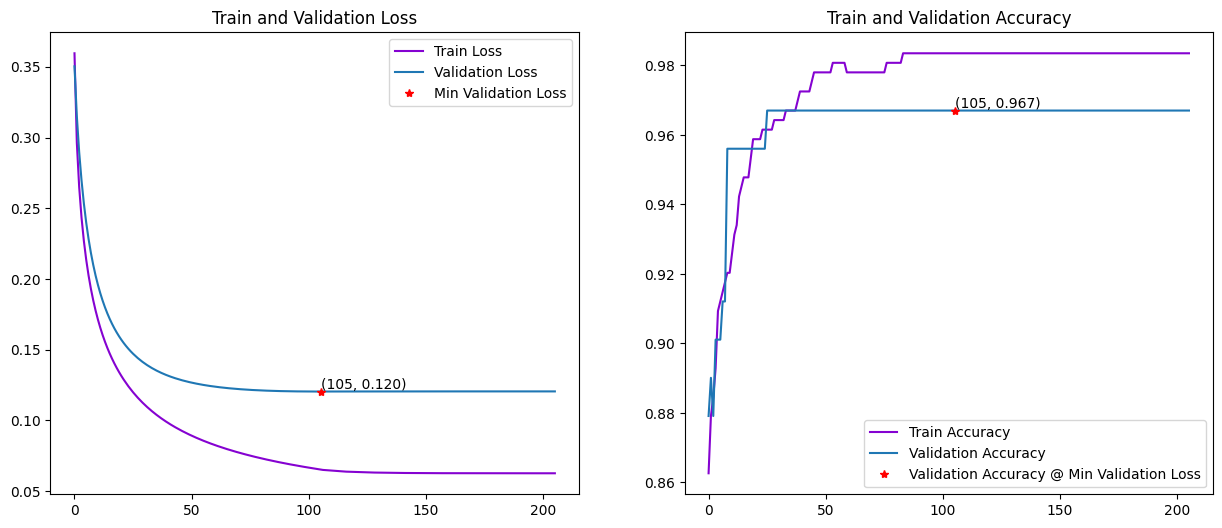

------------------------------------------------------------------------------------------------------------------
Batch Size = 128


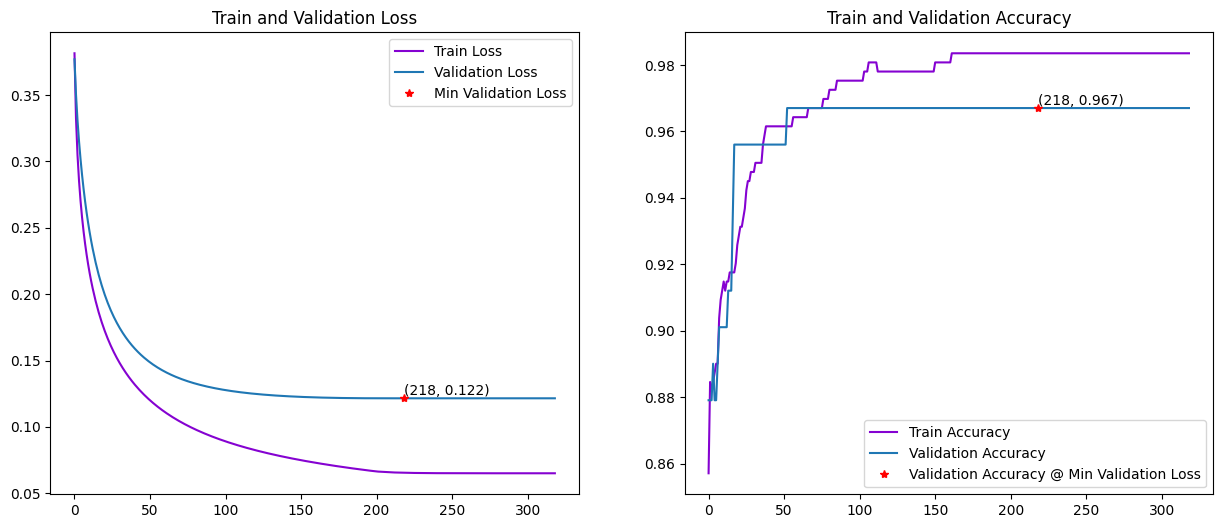

In [78]:
df_batch_size = pd.DataFrame(columns=['Batch Size', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss'])

for batch_size in [1, 2, 4, 8, 16, 32, 64, 128]:
    print(f'------------------------------------------------------------------------------------------------------------------')
    print(f'Batch Size = {batch_size}')    
        
    model.set_weights(CURRENT_MODEL.get_weights())   

    history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=batch_size, en_early_stopping=True, en_reduce_lr=True, verbose=0)
    proc_data = proc_history(history)
    
    new_row = {'Batch Size': batch_size, **proc_data}
    df_batch_size.loc[len(df_batch_size)] = new_row
    model_history(history)
